# Training decoder and autoencoders on MNIST

Here we train an auto-encoder on subsamples of the MNIST data in two different ways:

1. Training the decoder alone by optimizing both the weights of the decoder AND the representations for the training set.
2. Training an autoencoder in the usual fasion
3. Training an autoencoder with the decoder from 1 fixed

A lot of the code was taken from or inspired by this implementation of a VAE:
https://github.com/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb

We are grateful to paulguerrero for making the code available

This notebook contains experiments for a paper submitted to NeurIPS 2021 entitled:
A manifold learning perspective on representation learning and training of autoencoders

NOTE: In the submitted paper, the x-axis ia wrong in figure 4. It is corrected in this updated notebook. The exact numbers also differ due to difference in seeds of the random number generator.



## Libraries and Parameters 

In [7]:
import sys
import os
import math
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

# Global parameters
batch_size = 128
latent_dims = 20
input_dims = 28*28
capacity = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"

run_name = 'MNISTrun2'
file_name = r'C:\Users\beezy\Documents\Uni\DecoderWithoutEncoder\results\tmp_data' + run_name



## Download data and define classes for train and test data

The train data can be subsampled: A random subset of the full training set is used.

In [8]:
import torch
import torchvision
import numpy

!if [ ! -e MNIST ]; then wget www.di.ens.fr/~lelarge/MNIST.tar.gz; tar -zxf MNIST.tar.gz; fi

#!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
#!tar -zxf MNIST.tar.gz

from torchvision import transforms
from torchvision.datasets import MNIST

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# To get indices, we need to wrap the torchvision Dataset
# We also make it possible to sub-sample

class TrainDataset(torch.utils.data.Dataset):

  def __init__(self,nsample=0):
    super(TrainDataset, self).__init__()
    self.mnist = torchvision.datasets.MNIST(
      root="./", train=True, transform=transform, download=True
    )
    self.mnist_len = len(self.mnist)
    self.nsample=self.mnist_len
    self.ranindex=None
    self.set_nsample(nsample)

  # If nsample is changed (calling this function), the order is resampled
  def set_nsample(self,nsample):
    if nsample>0:
      self.nsample=nsample
      self.ranindex = torch.randperm(self.mnist_len)

  def __getitem__(self, index):
    rindex = index
    if self.nsample>0:
      rindex = self.ranindex[index]
    data, target = self.mnist[rindex]
    # Return the given index (not rindex), because this is used for the representation
    return data,target,index

  def __len__(self):
    return self.nsample



class TestDataset(torch.utils.data.Dataset):
  def __init__(self, nsample=0):
    super(TestDataset, self).__init__()
    self.mnist = torchvision.datasets.MNIST(
      root="./", train=False, transform=transform, download=True
    )
    self.mnist_len = len(self.mnist)
    self.nsample=self.mnist_len
    self.ranindex=None
    self.set_nsample(nsample)

  # If nsample is changed (calling this function), the order is resampled
  def set_nsample(self,nsample):
    if nsample>0:
      self.nsample=nsample
      self.ranindex = torch.randperm(self.mnist_len)

  def __getitem__(self, index):
    rindex = index
    if self.nsample>0:
      rindex = self.ranindex[index]
    data, target = self.mnist[rindex]
    # Return the given index (not rindex), because this is used for the representation
    return data,target,index

  def __len__(self):
    return self.nsample



"!" kann syntaktisch an dieser Stelle nicht verarbeitet werden.


## Class for internal representations

In [9]:

'''
Learn representations directly
'''

class RepresentationLayer(torch.nn.Module):
  '''
  Implements a representation layer, that accumulates pytorch gradients.
  To update representation, the pytorch framework does not work well, so
  the module comes with it's own SGD update (self.update(lr,mom,...)).
  Do not forget to call zero_grad after an epoch
  '''
  def __init__(self, nrep, nsample,
                rep_activity=(1.,1.),      # Normal distribution mean and stddev
                norm=True                  # Normalize representation
              ):
    super(RepresentationLayer, self).__init__()
    self.nrep=nrep
    self.nsample=nsample
    self.mean, self.stddev = rep_activity[0],rep_activity[1]
    self.norm = norm
    self.init_rep(rep_activity[0],rep_activity[1])
    self.dz = None

  def init_rep(self,mean,stddev):
    # Generate random activities
    self.z = torch.nn.Parameter(torch.normal(mean,stddev,size=(self.nsample,self.nrep), requires_grad=True))
    #self.clamp()

  def clamp(self):
    with torch.no_grad():
      if self.norm:
        self.z.clamp_(min=0)
        norm = 1./self.z.mean()
        self.z.mul_(norm)
      else:
        self.z.clamp_(min=0)

  def zero_grad(self):
    if self.z.grad is not None:
      self.z.grad.detach_()
      self.z.grad.zero_()

  def fix(self):
    self.z.requires_grad = False

  def unfix(self):
    self.z.requires_grad = True

  def forward(self, idx):
    if idx is None:
      return self.z
    else:
      return self.z[idx]

  # Index can be whatever it can be for a torch.tensor (e.g. tensor of idxs)
  def __getitem__(self,index):
    return self.z[index]

  def update(self,idx,lr=0.001,mom=0.9,wd=None):
    device = self.z.device
    if self.dz is None:
      self.dz = torch.zeros(self.z.size()).to(device)
    with torch.no_grad():
      # Update z
      # dz(k,j) = sum_i grad(k,i) w(i,j) step(z(j))
      self.dz[idx] = self.dz[idx].mul(mom) - self.z.grad[idx].mul(lr)
      if wd is not None:
        self.dz[idx] -= wd*self.z[idx]
      self.z[idx] += self.dz[idx]
      #self.clamp()


## Encoder and Decoder definitions

Also a few utility functions like the function for reconstruction loss

In [10]:

# A lot of this is from https://github.com/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb
# Thanks to paulguerrero for making the code available

class EncoderCNN(nn.Module):
  def __init__(self,c):
    super(EncoderCNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
    self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
    self.fc = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
            
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
    x = self.fc(x)
    return x

class DecoderCNN(nn.Module):
  def __init__(self,c):
    super(DecoderCNN, self).__init__()
    self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
    self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
    self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)
        
  def forward(self, x):
    x = self.fc(x)
    x = x.view(x.size(0), capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
    x = F.relu(self.conv2(x))
    x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
    return x


def count_params(model):
  num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  return num_params

def recon_loss(recon_x, x):
  recon_loss = F.binary_cross_entropy(recon_x.view(-1, input_dims), x.view(-1, input_dims), reduction='sum')
  return recon_loss



## Training functions

In [11]:
def Decoder_train_and_test(data,nsample,nepocs,lr,lr_rep,mom_rep=0.9,wd=0,print_progress=10,decoder=None):
  ''' If decoder is not None, the representation is optimized for the
      sample with a fixed decoder
  '''
  if decoder is None:
    # GLOBAL variables: capacity, latent_dims, device
    train_decoder=1
    decoder=DecoderCNN(capacity).to(device)
    decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr, weight_decay=wd)
  else:
    train_decoder=0

  # Initialize representations for the dataset
  representation = RepresentationLayer(latent_dims,nsample).to(device)

  # Representations can be optimized with adam, but using our own hack instead
  # because it seems to work better
  #representation_optimizer = torch.optim.Adam(representation.parameters(), lr=lr_rep)

  train_avg = []
  for epoch in range(nepocs):
    train_avg.append(0)
    num_batches = 0

    representation.zero_grad()
    for x, t, i in data:
      if train_decoder:
        decoder_optimizer.zero_grad()

      x = x.to(device)

      # compute reconstructions
      z = representation(i)
      y = decoder(z)

      # compute loss
      loss = recon_loss(y,x)
      loss.backward()

      representation.update(i,lr=lr_rep,mom=mom_rep)
      #representation_optimizer.step()

      if train_decoder:
        decoder_optimizer.step()

      train_avg[-1] += loss.item()
      num_batches += 1
    train_avg[-1] /= nsample*input_dims
    if print_progress and (epoch+1)%print_progress==0:
      print('Epoch %d average reconstruction error: %f' % (epoch+1, train_avg[-1]))
  return decoder, representation, train_avg


def trainDecoder(data,nsample,nepocs,lr,lr_rep,mom_rep=0.9,wd=0,print_progress=10):
  return Decoder_train_and_test(data,nsample,nepocs,lr,lr_rep,mom_rep=mom_rep,wd=wd,print_progress=print_progress)

def reconstruct_from_decoder(data,nsample,decoder,nepocs,lr,mom=0.9,wd=0,print_progress=10):
  decoder,rep,err = Decoder_train_and_test(data,nsample,nepocs,0,lr,mom_rep=mom,wd=wd,print_progress=print_progress,decoder=decoder)
  return rep.z,err


def trainAutoencoderFromDecoder(data,nepocs,lr,wd=0,print_progress=10,decoder=None):

  encoder=EncoderCNN(capacity).to(device)

  if decoder is None:
    decoder=DecoderCNN(capacity).to(device)
    train_decoder=1
  else:
    train_decoder=0

  if train_decoder:
    optimizer = torch.optim.Adam(list(encoder.parameters())+list(decoder.parameters()), lr=lr, weight_decay=wd)
  else:
    optimizer = torch.optim.Adam(encoder.parameters(), lr=lr, weight_decay=wd)

  train_avg = []
  for epoch in range(nepocs):
    train_avg.append(0)
    num_batches = 0
    nsample = 0

    for x, t, i in data:
      optimizer.zero_grad()
      x = x.to(device)

      nsample+=x.shape[0]

      # compute reconstructions
      z = encoder(x)
      y = decoder(z)

      # compute loss
      loss = recon_loss(y,x)
      loss.backward()

      optimizer.step()
    
      train_avg[-1] += loss.item()
      num_batches += 1
    train_avg[-1] /= nsample*input_dims
    if print_progress and (epoch+1)%print_progress==0:
      print('Epoch %d average reconstruction error: %f' % (epoch+1, train_avg[-1]))
  return nn.Sequential(encoder,decoder),train_avg


def trainAutoencoder(data,nepocs,lr,wd=0,print_progress=10):
  return trainAutoencoderFromDecoder(data,nepocs,lr,wd=wd,print_progress=print_progress)


## Training for various sample sizes

In [12]:
sample_size = [500,1000,2000,3000,4000,5000,6000,7000,8000,10000,12000,15000]
#sample_size = [8000,10000,12000,15000]

run_name = 'MNISTrun1'

# Seed for test set. For each sample size a new seed it set in the loop below.
torch.manual_seed(12345)

test_dataset = TestDataset(nsample=1000)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

nepochs = 200
learn_rate = 1.e-3
weight_decay=1.e-5
rep_learn_rate = 1.e-2
mom=0.9

table=dict()
table["Sample size"] = []
table["Decoder train"] = []
table["Decoder test"] = []
table["AE train"] = []
table["AE test"] = []
table["Encoder train"] = []
table["Encoder test"] = []
table["Decoder alpha"] = []
table["Encoder alpha"] = []

for nsample in sample_size:
  torch.manual_seed(54321+nsample)
  train_dataset = TrainDataset(nsample)
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  decoder,representation,error_decoder=trainDecoder(train_loader,nsample,nepochs,learn_rate,rep_learn_rate,
                                     mom_rep=mom,print_progress=0,wd=weight_decay)
  table["Decoder train"].append(error_decoder[-1])
  encoder, error_encoder=trainAutoencoderFromDecoder(train_loader,nepochs,learn_rate,print_progress=0,wd=weight_decay,decoder=decoder)
  table["Encoder train"].append(error_encoder[-1])
  autoencoder, error_ae=trainAutoencoder(train_loader,nepochs,learn_rate,print_progress=0,wd=weight_decay)
  table["AE train"].append(error_ae[-1])
 
  Cd = count_params(decoder)
  table["Decoder alpha"].append(input_dims*nsample/(Cd+latent_dims*nsample))
  Ca = count_params(autoencoder)
  table["Encoder alpha"].append(latent_dims*nsample/(Ca-Cd))

  z,recon_err = reconstruct_from_decoder(test_loader,len(test_dataset),decoder,nepochs,rep_learn_rate,mom=mom,print_progress=0)
  a_loss = d_loss = e_loss = 0
  for x,t,i in test_loader:
    x = x.to(device)
    with torch.no_grad():
      a_x = autoencoder(x)
      d_x = decoder(z[i])
      e_x = encoder(x)
      a_loss += recon_loss(a_x, x).item()
      d_loss += recon_loss(d_x, x).item()
      e_loss += recon_loss(e_x, x).item()
  table["AE test"].append(a_loss/ input_dims / len(test_dataset) )
  table["Decoder test"].append(d_loss/ input_dims / len(test_dataset) )
  table["Encoder test"].append(e_loss/ input_dims / len(test_dataset) )
  table["Sample size"].append(nsample)

  print(nsample,
        "train:",table["AE train"][-1],table["Decoder train"][-1],table["Encoder train"][-1],
        "test:",table["AE test"][-1],table["Decoder test"][-1],table["Encoder test"][-1])

  # Because of colab problems, we save results in each round
  fn = file_name+'_' + str(nsample) + '.table'
  with open(fn, 'w') as f:
    print(table, file=f)

print("Number of parameters, Decoder", Cd, " Autoencoder", Ca)

df=pd.DataFrame(data=table,index=sample_size)
fn = file_name+'.csv'
df.to_csv(fn)


500 train: 0.06454631447305485 0.06256948042889031 0.07012782131895727 test: 0.15145520517777425 0.10313772769850128 0.1498791765485491
1000 train: 0.06422214803890307 0.06188835050621811 0.06841231739277742 test: 0.12667406479193238 0.09322810706313775 0.1333598408601722
2000 train: 0.0678455991161113 0.06519512067522322 0.0725991045893455 test: 0.10584110306720344 0.08870298362264828 0.1273035029197226
3000 train: 0.0687504658601722 0.06622703998591624 0.07174486889482355 test: 0.09896072574537627 0.08420112641003666 0.12378465924944196
4000 train: 0.06953463881356375 0.06723357321291554 0.0732818834343735 test: 0.0963641021105708 0.08259543843172033 0.12162475835060588
5000 train: 0.07002728856923629 0.06768887442763971 0.07492160697469906 test: 0.09320125906808036 0.08262399603396045 0.12308980638153699
6000 train: 0.0703498572524713 0.06776431077191619 0.07483314950125558 test: 0.09050465237364477 0.08011261110889668 0.11747132966956313
7000 train: 0.07031359498493873 0.0685526643

## Recover split run

In [13]:
# If run was interrupted after nsample and then restarted, you can recover the full table:

def recover_table(nsample, filename, last_sample = 15000):
  with open(filename + '_' +str(nsample)+'.table', 'r') as f:
    ll = f.readline()
  table = dict()
  table = eval(ll)

  with open(filename + '_' +str(last_sample)+'.table', 'r') as f:
    ll = f.readline()
  tab2 = dict()
  tab2 = eval(ll)

  for key in table.keys():
    table[key].extend(tab2[key])
  return pd.DataFrame(data=table,index=table['Sample size'])


# Recover table and write file
table = recover_table(7000, file_name)
fn = file_name+'.csv'
table.to_csv(fn)
table

,Sample size,Decoder train,Decoder test,AE train,AE test,Encoder train,Encoder test,Decoder alpha,Encoder alpha
500,500,0.062569,0.103138,0.064546,0.151455,0.070128,0.149879,1.431320,0.038798
1000,1000,0.061888,0.093228,0.064222,0.126674,0.068412,0.133360,2.761798,0.077595
2000,2000,0.065195,0.088703,0.067846,0.105841,0.072599,0.127304,5.160050,0.155190
3000,3000,0.066227,0.084201,0.068750,0.098961,0.071745,0.123785,7.262106,0.232786
4000,4000,0.067234,0.082595,0.069535,0.096364,0.073282,0.121625,9.119646,0.310381
5000,5000,0.067689,0.082624,0.070027,0.093201,0.074922,0.123090,10.772989,0.387976
6000,6000,0.067764,0.080113,0.070350,0.090505,0.074833,0.117471,12.254053,0.465571
7000,7000,0.068553,0.080895,0.070314,0.089762,0.076015,0.122775,13.588430,0.543166
500,500,0.062569,0.103138,0.064546,0.151455,0.070128,0.149879,1.431320,0.038798
1000,1000,0.061888,0.093228,0.064222,0.126674,0.068412,0.133360,2.761798,0.077595


## Plots

The first plot includes the autoencoder with fixed decoder (labeled "decoder"). It is mentioned and discussed in the paper, but not included.

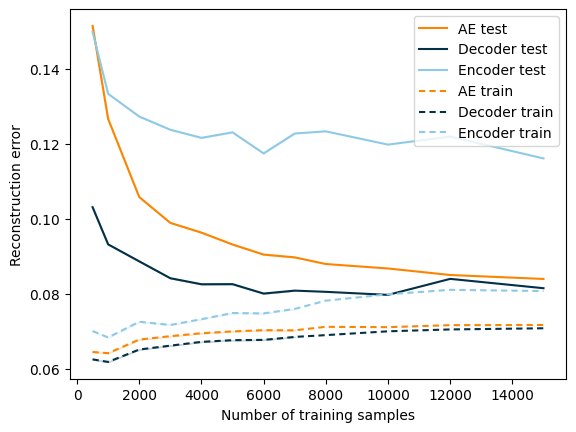

In [14]:
import matplotlib.pyplot as plt
import seaborn as sea

table = pd.read_csv(file_name+'.csv',index_col='Sample size')

df = table[["AE test","Decoder test","Encoder test","AE train","Decoder train","Encoder train"]]

#my_colors = ['#8ecae6', '#219ebc', '#023047', '#ffb703', '#fb8500']
my_colors = ['#fb8500', '#023047','#8ecae6','#fb8500', '#023047', '#8ecae6']
line_types = ["","","",(3,2),(3,2),(3,2)]

plt.xlabel("Number of training samples")
plt.ylabel("Reconstruction error")

sea.lineplot(data=df,palette=my_colors,
             dashes=line_types)
plt.savefig(file_name+'_dec.pdf')

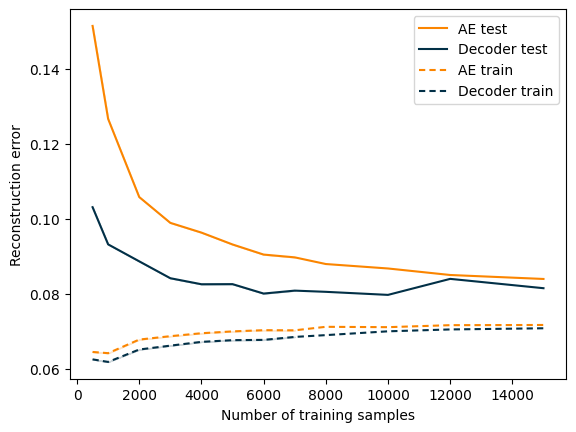

In [15]:

df = table[["AE test","Decoder test","AE train","Decoder train"]]

#my_colors = ['#8ecae6', '#219ebc', '#023047', '#ffb703', '#fb8500']
my_colors = ['#fb8500', '#023047','#fb8500', '#023047']
line_types = ["","",(3,2),(3,2)]

plt.xlabel("Number of training samples")
plt.ylabel("Reconstruction error")

sea.lineplot(data=df,palette=my_colors,
             dashes=line_types)
plt.savefig(file_name+'_no_dec.pdf')


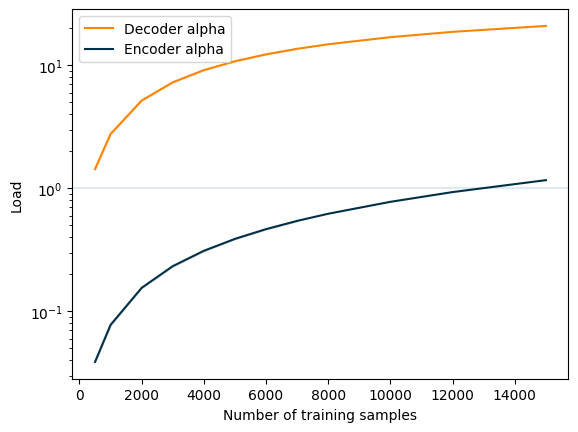

In [17]:
df = table[["Decoder alpha","Encoder alpha"]]

#my_colors = ['#8ecae6', '#219ebc', '#023047', '#ffb703', '#fb8500']
my_colors = ['#fb8500', '#023047']
line_types = ["",""]

plt.xlabel("Number of training samples")
plt.ylabel("Load")
plt.axhline(1.0,lw=0.2)
#plt.axhline(0.01)

myplt = sea.lineplot(data=df,palette=my_colors,dashes=line_types)
myplt.set(yscale="log")

plt.savefig(r'C:\Users\beezy\Documents\Uni\DecoderWithoutEncoder\results\tmp_data'+run_name+'_alpha.pdf')
